In [1]:
import numpy as np
import qiskit.pulse as pulse
from qiskit_ibm_provider import IBMProvider

from casq.gates import GaussianPulseGate
from casq.common import plot, plot_bloch, plot_signal, LineStyle, LineType, LineConfig, LegendStyle
from casq import PulseSolver

%matplotlib inline


In [2]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
from qiskit_dynamics.array import Array
Array.set_default_backend("jax")


In [3]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
config = backend.configuration()
properties = backend.properties()
solver = PulseSolver.from_backend("ibmq_manila", qubits=[0])


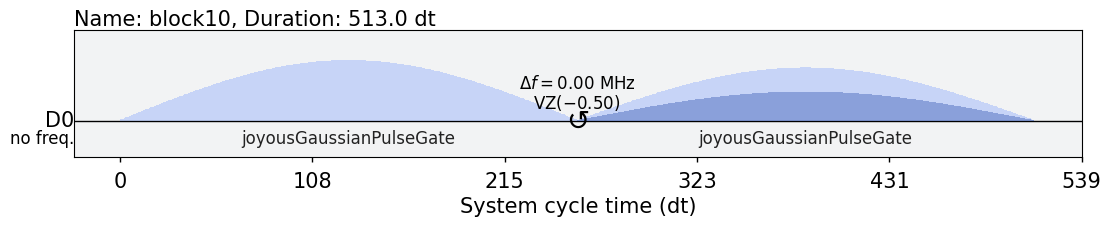

In [4]:
dt = config.dt
qubit = 0
qubit_frequency = properties.frequency(qubit)
duration = 256
sigma = 128

schedules = []

for amplitude in np.linspace(0., 1., 10):
    gpg = GaussianPulseGate(duration, amplitude, sigma)
    with pulse.build() as schedule:
        with pulse.align_sequential():
            gpg.instruction(qubit)
            pulse.shift_phase(0.5, pulse.DriveChannel(qubit))
            pulse.shift_frequency(0.1, pulse.DriveChannel(qubit))
            gpg.instruction(qubit)
            pulse.acquire(duration=1, qubit_or_channel=qubit, register=pulse.MemorySlot(qubit))

    schedules.append(schedule)

schedules[5].draw()


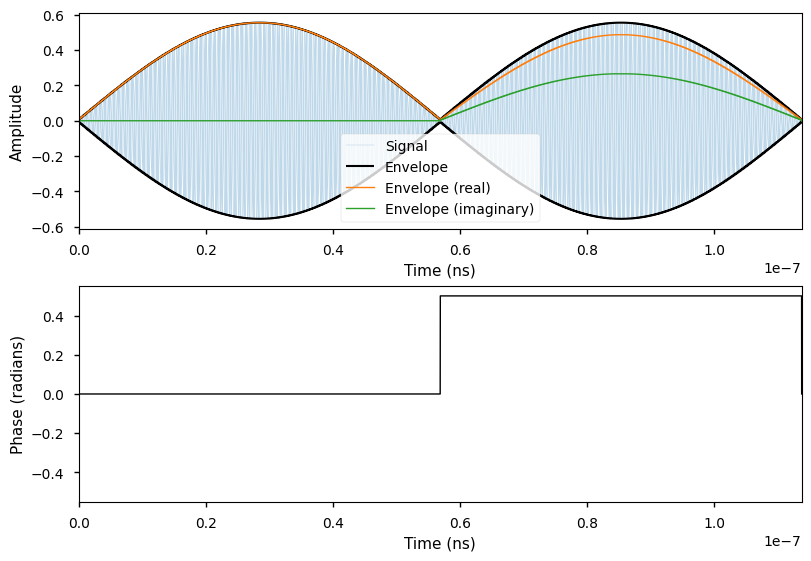

In [5]:
fig = plot_signal(schedules[5], dt, "d0", qubit_frequency, 2*duration*dt)


In [11]:
solutions = {}
for schedule in schedules:
    solution = solver.solve(
        run_input=schedule, steps=100, shots=1024,
        method="jax_odeint", atol=1e-6, rtol=1e-8, hmax=dt
    )
    solutions[schedule.name] = solution


In [13]:
solution = solutions[schedules[-1].name]
print(solution.populations)


[{'0': 1.0}, {'0': 0.9994701829139844, '1': 0.0005298170860156706}, {'0': 0.9940717723108715, '1': 0.005928227689128395}, {'0': 0.9723454607331236, '1': 0.027654539266876492}, {'0': 0.9215553102310354, '1': 0.07844468976896427}, {'0': 0.821154133287672, '1': 0.17884586671232774}, {'0': 0.6635904619737522, '1': 0.33640953802624746}, {'0': 0.458553846442793, '1': 0.5414461535572072}, {'0': 0.22832826952566235, '1': 0.7716717304743373}, {'0': 0.05810772970407177, '1': 0.9418922702959284}, {'0': 0.01209210503009231, '1': 0.9879078949699077}, {'0': 0.15711825793252457, '1': 0.8428817420674756}, {'0': 0.4604830583912502, '1': 0.5395169416087496}, {'0': 0.8124809923370521, '1': 0.1875190076629482}, {'0': 0.9917336917906714, '1': 0.00826630820932881}, {'0': 0.8718669883518041, '1': 0.12813301164819593}, {'0': 0.4951822810298842, '1': 0.5048177189701157}, {'0': 0.11397900985325699, '1': 0.8860209901467431}, {'0': 0.03450197349079695, '1': 0.9654980265092035}, {'0': 0.3396777936247695, '1': 0.66

In [23]:
x = []
y = []
z = []
for state in solution.states:
    xp, yp, zp = state.data.real
    x.append(xp)
    y.append(yp)
    z.append(zp)
p0 = []
p1 = []
for pop in solution.populations:
    p0.append(pop.get("0", 0))
    p1.append(pop.get("1", 0))


[0.00000000e+00 1.14927048e-09 2.29854097e-09 3.44781145e-09
 4.59708193e-09 5.74635241e-09 6.89562290e-09 8.04489338e-09
 9.19416386e-09 1.03434343e-08 1.14927048e-08 1.26419753e-08
 1.37912458e-08 1.49405163e-08 1.60897868e-08 1.72390572e-08
 1.83883277e-08 1.95375982e-08 2.06868687e-08 2.18361392e-08
 2.29854097e-08 2.41346801e-08 2.52839506e-08 2.64332211e-08
 2.75824916e-08 2.87317621e-08 2.98810325e-08 3.10303030e-08
 3.21795735e-08 3.33288440e-08 3.44781145e-08 3.56273850e-08
 3.67766554e-08 3.79259259e-08 3.90751964e-08 4.02244669e-08
 4.13737374e-08 4.25230079e-08 4.36722783e-08 4.48215488e-08
 4.59708193e-08 4.71200898e-08 4.82693603e-08 4.94186308e-08
 5.05679012e-08 5.17171717e-08 5.28664422e-08 5.40157127e-08
 5.51649832e-08 5.63142536e-08 5.74635241e-08 5.86127946e-08
 5.97620651e-08 6.09113356e-08 6.20606061e-08 6.32098765e-08
 6.43591470e-08 6.55084175e-08 6.66576880e-08 6.78069585e-08
 6.89562290e-08 7.01054994e-08 7.12547699e-08 7.24040404e-08
 7.35533109e-08 7.470258

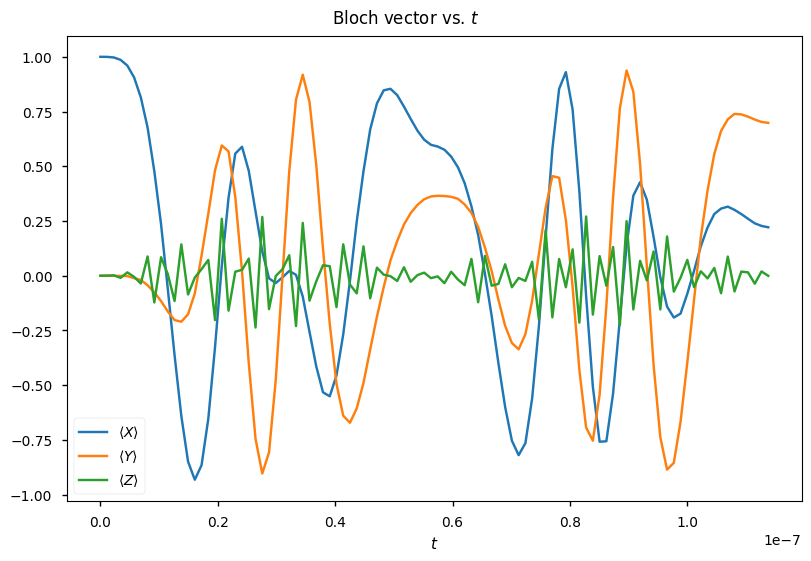

In [18]:
x_config = LineConfig(x=solution.time, y=x, label="$\\langle X \\rangle$", xtitle="$t$")
y_config = LineConfig(x=solution.time, y=y, label="$\\langle Y \\rangle$", xtitle="$t$")
z_config = LineConfig(x=solution.time, y=z, label="$\\langle Z \\rangle$", xtitle="$t$")
fig = plot(
    data=[x_config, y_config, z_config],
    title="Bloch vector vs. $t$", legend_style=LegendStyle()
)


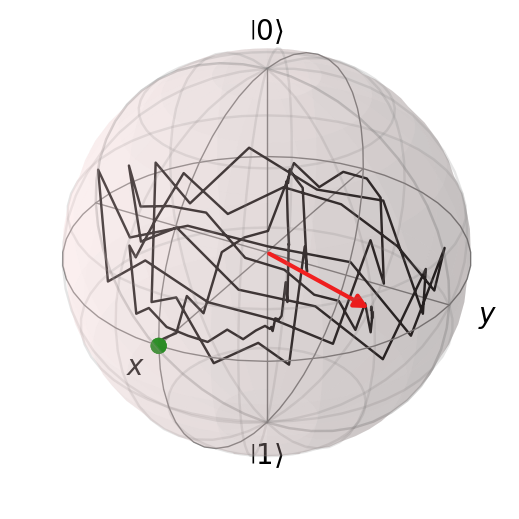

In [19]:
fig = plot_bloch(x, y, z)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

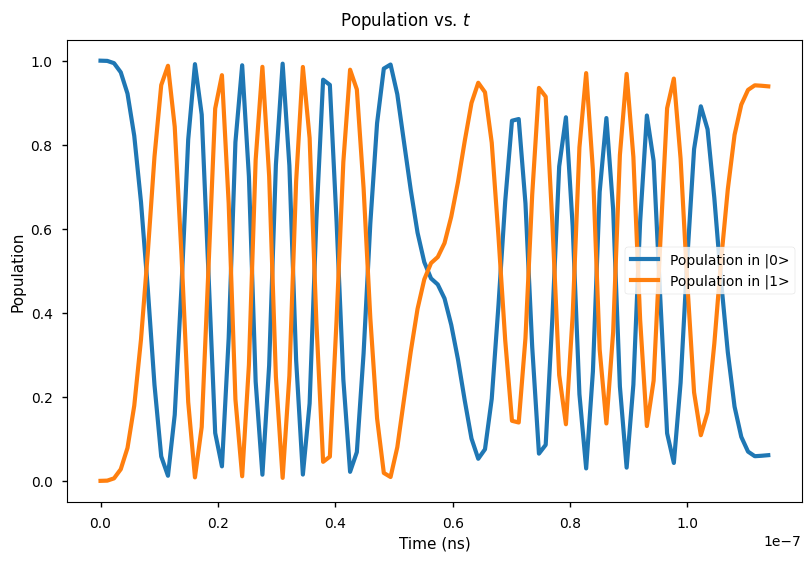

In [24]:
p0_config = LineConfig(
    x=solution.time, y=p0, label="Population in |0>",
    line_style=LineStyle(size=3), xtitle="Time (ns)", ytitle="Population"
)
p1_config = LineConfig(
    x=solution.time, y=p1, label="Population in |1>",
    line_style=LineStyle(size=3), xtitle="Time (ns)", ytitle="Population"
)
vline = (0.5*solution.time, None, LineStyle(type=LineType.DASHED, color="black"), None)
fig = plot(
    data=[p0_config, p1_config],
    vlines=[vline],
    title="Population vs. $t$", legend_style=LegendStyle()
)
